In [1]:
import sqlite3
import pandas as pd
import numpy as np
import time
import pickle
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.moses import MosesDetokenizer
from stop_words import get_stop_words
from collections import defaultdict
import gensim
from gensim import corpora, models, similarities
from gensim.models.doc2vec import TaggedDocument,TaggedLineDocument
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from random import randint 
from IPython.display import Image

## UVA PLOS Capstone Demo 
#### 3.2.18

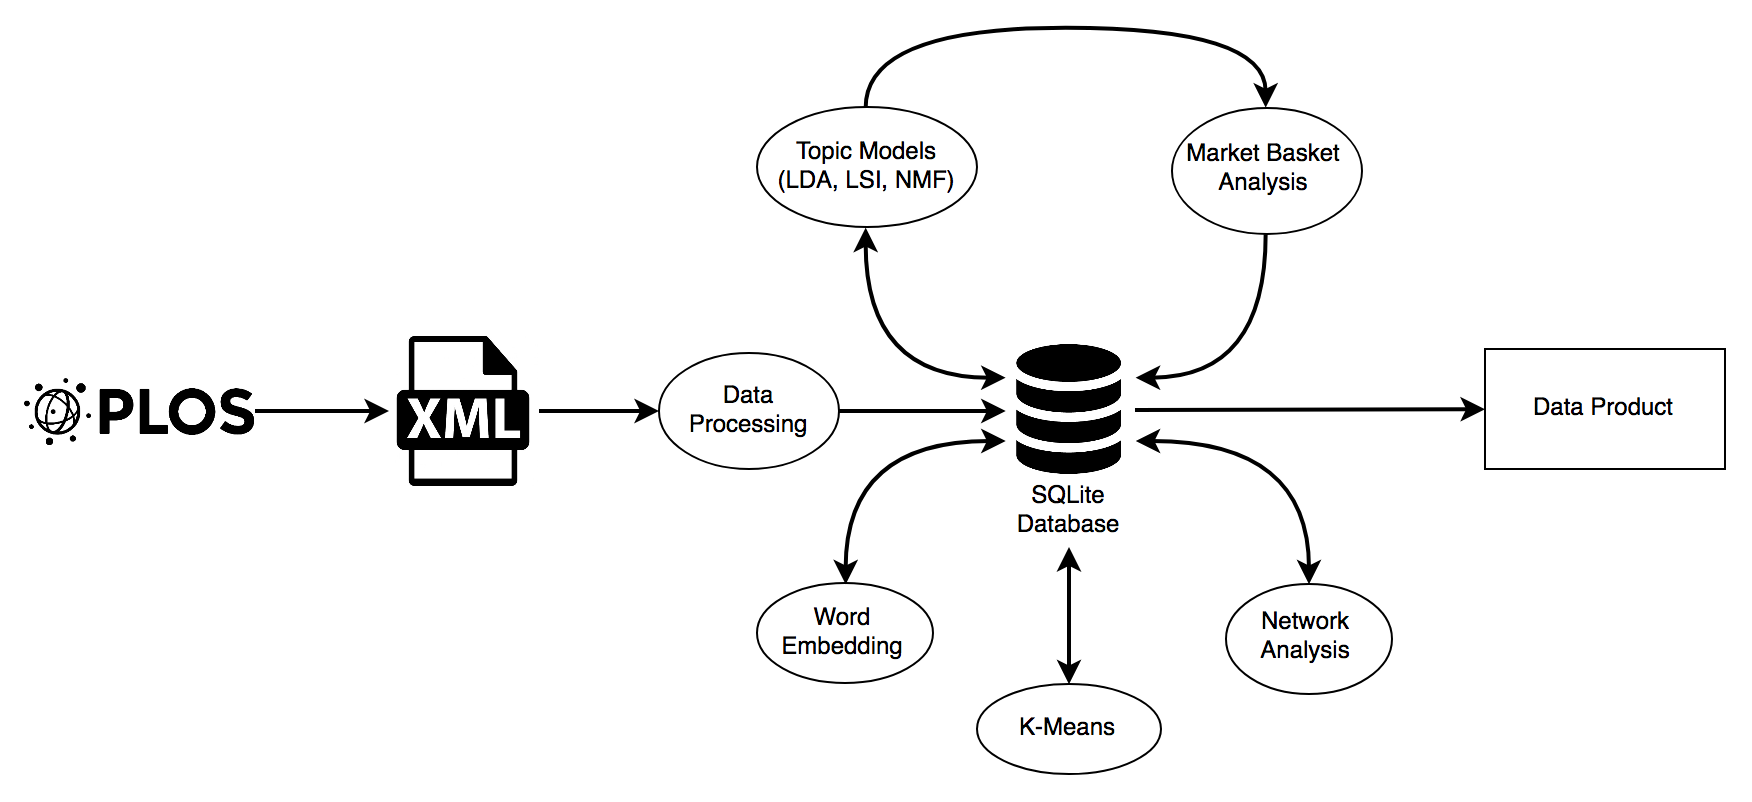

In [8]:
Image('/volume/dataflow.png', width=1000)

In [2]:
conn = sqlite3.connect("/volume/testDB.db")
df = pd.read_sql('SELECT doi,title,editors from PLOS_ALL', conn)

In [3]:
df.head()

,doi,title,editors
0,10.1371/journal.pone.0143437,Distribution Features of Skeletal Metastases: ...,['Harriet Wikman']
1,10.1371/journal.pone.0096769,Voice Disorder in Cystic Fibrosis Patients,['Donald A. Robin']
2,10.1371/journal.pone.0177044,Comorbidity and progression of late onset Alzh...,['Stephen D. Ginsberg']
3,10.1371/journal.pone.0033200,Effect of Polymorphisms in,['Alfons Navarro']
4,10.1371/journal.pone.0001814,Anchor Side Chains of Short Peptide Fragments ...,['Mauricio Martins Rodrigues']


In [4]:
# Load saved model files
lsi = models.LsiModel.load('/volume/models/model.lsi')
lda = models.LdaModel.load('/volume/models/model.lda')
tfidf = models.TfidfModel.load('/volume/models/model.tfidf')
index = similarities.MatrixSimilarity.load('/volume/models/similarity.index')
corpus = corpora.MmCorpus('/volume/models/corpus.mm')
dictionary = corpora.Dictionary.load('/volume/models/dictionary.dict')
model = Doc2Vec.load('/volume/models/features-w2v-200.doc2vec')
tax_lsi = models.LsiModel.load('/volume/models/tax_model.lsi')
tax_lda = models.LdaModel.load('/volume/models/tax_model.lda')

In [7]:
# Transform corpus
corpus_tfidf = tfidf[corpus]
corpus_lsi = lsi[corpus_tfidf]
corpus_lda = lda[corpus_tfidf]

corpus_taxlsi = tax_lsi[corpus_tfidf]
corpus_taxlda = tax_lda[corpus_tfidf]

### Topic Modeling (LSA / LDA)

Topic modeling is a technique for the discovery of hidden (or "latent") semantic structures in a corpus. Each document is described in terms of one or more "topics," which are made up of the most common words in that topic. These unobserved semantic relationships can be used to ascertain similarity between documents. Topic weights can also be used as inputs for other analysis methods, like association rule learning.

In [ ]:
tax_lda.show_topics()

#### Print 5 random topics

In [13]:
print('LSI Topics')
print()
for i in range(0,5):
    x = randint(0,200)
    print('Topic ' + str(x) + ': ' + lsi.print_topic(x))
    print()

print('---------')
print()
print('LDA Topics')
print()
for i in range(0,6):
    x = randint(0,200)
    print('Topic ' + str(x) + ': ' + lda.print_topic(x))
    print()

LSI Topics

Topic 140: -0.304*"gener" + -0.240*"site" + 0.201*"domain" + -0.195*"methyl" + -0.187*"antibodi" + -0.177*"includ" + -0.166*"line" + -0.156*"soil" + 0.144*"mechan" + -0.140*"promot"

Topic 102: -0.464*"may" + 0.195*"sever" + -0.174*"liver" + 0.167*"role" + -0.150*"year" + 0.148*"found" + 0.136*"also" + 0.136*"host" + 0.135*"observ" + 0.133*"influenza"

Topic 32: -0.462*"treatment" + -0.254*"control" + -0.229*"risk" + 0.212*"test" + 0.209*"health" + -0.192*"dna" + 0.181*"group" + 0.152*"effect" + -0.144*"drug" + 0.143*"strain"

Topic 31: 0.482*"differ" + -0.378*"test" + -0.215*"control" + 0.181*"diseas" + -0.164*"develop" + 0.159*"sequenc" + -0.153*"popul" + 0.142*"mir" + 0.142*"type" + 0.140*"mirna"

Topic 177: 0.245*"present" + 0.213*"score" + 0.197*"breast" + -0.177*"hpv" + -0.167*"tlr" + -0.162*"complex" + -0.157*"assess" + -0.155*"correl" + 0.145*"reduc" + -0.130*"determin"

---------

LDA Topics

Topic 115: 0.089*"input" + 0.087*"choic" + 0.054*"oscil" + 0.051*"output"

#### Show topic weights of a given document

In [17]:
# Get a DOI
x = randint(0,200)
df.loc[x]['doi']

'10.1371/journal.pone.0027532'

In [19]:
doi_in = input('Enter a DOI: ')
qu_doi = df.loc[df['doi']==doi_in].index[0]
print('Title:',df.loc[qu_doi]['title'])
print()
topics = lda.get_document_topics(corpus[qu_doi],minimum_probability=.05)
topics = sorted(topics,key=lambda x: x[1],reverse=True)
print('Topic Weights:')
print(sorted(topics,key=lambda x: x[1],reverse=True))
print()
for i in range(3):
    print('Topic ' + str(topics[i][0]) + ': ')
    [print(x[0]) for x in lda.show_topic(topics[i][0])]
    print()


Title: Amoeboid Cells Use Protrusions for Walking, Gliding and Swimming

Topic Weights:
[(129, 0.17258556), (46, 0.16872697), (12, 0.117067024), (2, 0.08086467), (165, 0.07529377), (176, 0.07315826), (120, 0.059698403)]

Topic 129: 
cell
effector
line
function
specif
lymphocyt
human
activ
express
show

Topic 46: 
envelop
revers
glycoprotein
arthropod
env
render
cleav
pol
substitut
man

Topic 12: 
surfac
particl
releas
remov
electron
properti
materi
microscopi
coat
use



#### Most similar documents given doi

In [19]:
query_doi = input('Enter a DOI: ')
query_doc = df.loc[df['doi']==query_doi].index[0]
doc_bow = corpus[query_doc]

vec_lsi = lsi[doc_bow]
lsi_sims = sorted(enumerate(index[vec_lsi]), key=lambda item: -item[1])
simdocs_lsi = [x[0] for x in lsi_sims[1:11]]

vec_lda = lda[doc_bow]
lda_sims = sorted(enumerate(index[vec_lda]), key=lambda item: -item[1])
simdocs_lda = [x[0] for x in lda_sims[0:10]]

print('Target: ' + df.loc[query_doc,'title'])
print('')
print('LSI Most Similar Documents:')
for i in range(0,len(simdocs_lsi)):
    print(str(i+1) + '. ' + df.loc[simdocs_lsi[i],'title'])

Target: Measurement of Phospholipids May Improve Diagnostic Accuracy in Ovarian Cancer

LSI Most Similar Documents:
1. Development and Preliminary Evaluation of a Multivariate Index Assay for Ovarian Cancer
2. Systematic Evaluation of Candidate Blood Markers for Detecting Ovarian Cancer
3. Effects of Blood Collection Conditions on Ovarian Cancer Serum Markers
4. Knowledge about Cervical Cancer and Associated Factors among 15-49 Year Old Women in Dessie Town, Northeast Ethiopia
5. Comprehensive Serum Profiling for the Discovery of Epithelial Ovarian Cancer Biomarkers
6. Identification of BRCA1 Deficiency Using Multi-Analyte Estimation of BRCA1 and Its Repressors in FFPE Tumor Samples from Patients with Triple Negative Breast Cancer
7. An HR-MAS MR Metabolomics Study on Breast Tissues Obtained with Core Needle Biopsy
8. Development of Multiplexed Bead-Based Immunoassays for the Detection of Early Stage Ovarian Cancer Using a Combination of Serum Biomarkers
9. Definitive Characterization 

#### Most similar documents given search query (or abstract)

In [17]:
# Search treats the query as another document -- which links it to topics and the hidden semantic
# structures of the text. Then returns similarly topic weighted results. 

doc = input('Enter a search query: ')

vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow] # convert the query to LSI space
lsi_sims = sorted(enumerate(index[vec_lsi]), key=lambda item: -item[1])
simdocs_lsi = [x[0] for x in lsi_sims[0:10]]

for i in range(0,len(simdocs_lsi)):
    print(str(i+1) + '. ' + df.loc[simdocs_lsi[i],'title'])

1. Ten-Year Mortality after a Breast Cancer Diagnosis in Women with Severe Mental Illness: A Danish Population-Based Cohort Study
2. Breast Cancer Biology and Ethnic Disparities in Breast Cancer Mortality in New Zealand: A Cohort Study
3. Factors Associated with Uptake of Visual Inspection with Acetic Acid (VIA) for Cervical Cancer Screening in Western Kenya
4. Knowledge about Cervical Cancer and Associated Factors among 15-49 Year Old Women in Dessie Town, Northeast Ethiopia
5. Relationship between Cancer Worry and Stages of Adoption for Breast Cancer Screening among Korean Women
6. Women Commencing Anastrozole, Letrozole or Tamoxifen for Early Breast Cancer: The Impact of Comorbidity and Demographics on Initial Choice
7. Socio-Demographic and Geographical Factors in Esophageal and Gastric Cancer Mortality in Sweden
8. Black and White Women in Maryland Receive Different Treatment for Cervical Cancer
9. Innate Immunity Pathways and Breast Cancer Risk in African American and European-Am

### Word Embedding

Word Embedding is a neural network model to represent words and documents as numerical vectors. The goal is to learn word representations that can predict a document given its surrounding words and documents. This allows context to play a much larger role in document grouping, and thus potentially giving better querying results.

#### What are most and least similar to a given article?

In [5]:
doc_id = np.random.randint(model.docvecs.count) 
sims = model.docvecs.most_similar(doc_id, topn=model.docvecs.count)  # get *all* similar documents
print(u'TARGET (%d): %s' % (doc_id, ''.join(df.loc[doc_id]['title'])))
print(df.loc[sims[0][0]]['doi'])
print()

for label, index in [('MOST', 0), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: %s' % (label, sims[index], ''.join(df.loc[sims[index][0]]['title'])))
    print(df.loc[sims[index][0]]['doi'])
    print()

TARGET (176214): No Relationship between Embryo Morphology and Successful Derivation of Human Embryonic Stem Cell Lines
10.1371/journal.pone.0143632

MOST (57426, 0.5022608637809753): Oocyte Scoring Enhances Embryo-Scoring in Predicting Pregnancy Chances with IVF Where It Counts Most
10.1371/journal.pone.0143632

LEAST (184515, -0.26846593618392944): Assessing the facilitators and barriers of interdisciplinary team working in primary care using normalisation process theory: An integrative review
10.1371/journal.pone.0181893



In [11]:
sims = model.docvecs.most_similar(doc_id, topn=10)
simdocs = [x[0] for x in sims]
simdocs
df.loc[simdocs]

,doi,title,editors
57426,10.1371/journal.pone.0143632,Oocyte Scoring Enhances Embryo-Scoring in Pred...,['Samuel Kim']
144251,10.1371/journal.pone.0056189,Does the Number of Oocytes Retrieved Influence...,['Maurilio Sampaolesi']
94007,10.1371/journal.pone.0173724,"Soluble CD146, an innovative and non-invasive ...",['Yang Yu']
137670,10.1371/journal.pone.0090755,Hope for Restoration of Dead Valuable Bulls th...,['Christine Wrenzycki']
49384,10.1371/journal.pone.0110998,The Aggregation of Four Reconstructed Zygotes ...,['Jason Glenn Knott']
29888,10.1371/journal.pone.0022121,Cell Arrest and Cell Death in Mammalian Preimp...,['Joerg Gromoll']
70793,10.1371/journal.pone.0150588,Genealogical Trees of Scientific Papers,['Renaud Lambiotte']
58534,10.1371/journal.pone.0123178,Availability of Empty Zona Pellucida for Gener...,['Xiuchun Tian']
139026,10.1371/journal.pone.0045220,E-Cadherin Promotes Incorporation of Mouse Epi...,['Qiang Wu']
139243,10.1371/journal.pone.0095560,Birth of Healthy Offspring following ICSI in,['W. Steven Ward']


### Editor Recommendations

In [16]:
# Get an abstract, pretend it was just submitted

ab_doi = input('Enter a DOI: ')
a = list(df.abstract[df.doi == ab_doi])
a[0]

'More than two-thirds  women who undergo surgery for suspected ovarian neoplasm  not have cancer. Our previous results suggest phospholipids  potential biomarkers  ovarian cancer.  this study,  measured the serum levels  multiple phospholipids among women undergoing surgery for suspected ovarian cancer  identify biomarkers that better predict whether  ovarian mass  malignant.Methodology/Principal FindingsWe obtained serum samples preoperatively from women with suspected ovarian cancer enrolled through  prospective, population-based rapid ascertainment system. Samples were analyzed from all women  whom  diagnosis  epithelial ovarian cancer (EOC) was confirmed and from benign disease cases randomly selected from the remaining (non-EOC) samples.  measured biologically relevant phospholipids using liquid chromatography/electrospray ionization mass spectrometry.  applied  powerful statistical and machine learning approach, Hybrid huberized support vector machine (-SVM)  prioritize phospholi

In [14]:
# Generate Recommendations

doc = input('Enter a submission abstract: ')

vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow] # convert the query to LSI space
lsi_sims = sorted(enumerate(index[vec_lsi]), key=lambda item: -item[1])
simdocs_lsi = [x[0] for x in lsi_sims[0:10]]

editors = []
edits = []

for i in range(0,len(simdocs_lsi)):
    editors.append(df.loc[simdocs_lsi[i],'editors'].strip("[]'"))
    edits.append(sum(df.editors == df.loc[simdocs_lsi[i],'editors']))
    
print('')
print('Recommended Editors:')
ed_rec = pd.DataFrame({'Name':editors,'Number of Edits':edits})
ed_rec


Recommended Editors:


,Name,Number of Edits
0,Massimo Ciccozzi,83
1,Robert M Lafrenie,34
2,Kalimuthusamy Natarajaseenivasan,10
3,Dimitrios Paraskevis,105
4,Ali Montazeri,38
5,William B. Coleman,237
6,Mitsunobu R. Kano,25
7,Harry Zhang,92
8,Syed\xa0A. Aziz,5
9,Giampiero Favato,8


In [55]:
# What has an editor edited in the past? 

ed = input('Enter an editor: ')
df[['doi','title','date_pub','editors',]][df.editors.str.contains(ed)]

,doi,title,date_pub,editors
1089,10.1371/journal.pone.0151705,Relative Importance and Additive Effects of Ma...,2016-3-22,['Massimo Ciccozzi']
4010,10.1371/journal.pone.0138179,Inappropriate Use of Antibiotics and Its Assoc...,2015-9-17,['Massimo Ciccozzi']
5465,10.1371/journal.pone.0138175,Obesity and Aerobic Fitness among Urban Public...,2015-9-17,['Massimo Ciccozzi']
5506,10.1371/journal.pone.0153982,The Water Suitcase of Migrants: Assessing Virt...,2016-4-28,['Massimo Ciccozzi']
6422,10.1371/journal.pone.0178873,School and household tuberculosis contact inve...,2017-6-5,['Massimo Ciccozzi']
12055,10.1371/journal.pone.0154523,Effects of Malnutrition on Left Ventricular Ma...,2016-5-3,['Massimo Ciccozzi']
13004,10.1371/journal.pone.0140017,"Job Loss, Unemployment and the Incidence of Ha...",2015-10-7,['Massimo Ciccozzi']
14939,10.1371/journal.pone.0131900,An International Survey on Taking Up a Career ...,2015-7-17,['Massimo Ciccozzi']
15432,10.1371/journal.pone.0182460,Antimicrobial knowledge and confidence amongst...,2017-8-3,['Massimo Ciccozzi']
16977,10.1371/journal.pone.0123204,Incidence and Prevalence of Chronic Obstructiv...,2015-4-13,['Massimo Ciccozzi']
